In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb, lightgbm as lgbm,catboost as catb
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from itertools import permutations, combinations
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
matplotlib.rcParams.update({'font.size' : 14})

In [6]:
#Загрyзка данных
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [7]:
#Оценивать выбросы, смотреть пропуски, строить распределение и т.д. лучше на всем наборе данных
#Эта функция, объединяет данные из тестового и тренировочного наборов
def build_all_data(): 
    return data_train.drop(columns=['Credit Default']).append(data_test)

In [8]:
#Функция показывает как распределяется выбранный признак, а так же где на полученном графике: мода, медиана и среднее
def ShowDistribution(X, column, roundcoef=1, linespase_begin=5e-6, linespase_end=100):
    target_mean = round(X[column].mean(), 2)
    target_median = X[column].median()
    target_mode = round(X[column] / roundcoef).mode()[0]*roundcoef 
    plt.figure(figsize = (16, 8))

    sns.distplot(X[column])
    y = np.linspace(0, linespase_begin, linespase_end)
    plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title('Distribution of ' + column)
    plt.legend()
    plt.show()

In [9]:
#Для выбранного признака показывает, boxplot и описание
def present_feature(data, feature):
    print(data[feature].describe())
    sns.boxplot(data[feature])

In [10]:
#Для выбранного категориального признака показывает, описание и количество строк для каждого из значений признака
def present_categorical_feature(data, feature):
    print(data[feature].describe())
    print('--'*10)
    print(pd.get_dummies(all_data[feature]).sum())

In [11]:
#Из выбранного категориального признака строит dummy признаки
def make_dummy(data, feature):
    df = pd.get_dummies(data,prefix=None,columns=[feature], drop_first=True)
    for dummy_feature in df:
        data[dummy_feature] = df[dummy_feature]
    data.drop(columns=[feature], inplace=True)

In [12]:
def cat_text_to_number(all_data, data, feature):
    values = pd.get_dummies(all_data[feature]).columns.tolist()
    data[feature] = data[feature].map(lambda x: values.index(x))

In [13]:
#Расчитывает Хи-квадрат Пирсона для пары значений
def test_feature(data, feature, values, target):
    feature_and_target = data.loc[data[feature].isin(values), ['ID',feature, target]]
    table = feature_and_target.pivot_table(values='ID', index=feature, columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p

In [14]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred, digits=4))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [15]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [16]:
def CreatePriceFeature(df, columns, target,featurename):
    return df.groupby(columns)[[target]]\
                    .mean().reset_index()\
                    .rename(columns={target:featurename})

def MergePriceFeature(df, columns, featurename, feature):
    df = pd.merge(df, feature, on=columns, how='left')
    df.loc[df[featurename].isnull(), featurename]\
        = df[featurename].mode()    
    return df   

def ExpandDataOnPriceFeature(df, df_test, columns,target, featurename):
    feature = CreatePriceFeature(df,columns, target, featurename)
    df =  MergePriceFeature(df, columns, featurename, feature)
    df_test =  MergePriceFeature(df_test, columns, featurename, feature)
    return (df, df_test)

In [17]:
CAT_FEATURES = []
TARGET_NAME = 'Credit Default'

In [18]:
HELPER_FEATURE = 'exactly delay' 

#Пока обрабатываем выбросы и заполняем пробелы, на графиках увидим много закономерностей с целевой переменной.
#Этим закономерности будут постепенно вынесны в отдельный признак.
#Предположение, что это даст значительный прирост в качестве.

In [19]:
CAT_FEATURES.append(HELPER_FEATURE)

In [20]:
#1. Обзор обучающего датасета
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [21]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [23]:
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [24]:
data_train = optimizing_df(data_train)

In [26]:
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [27]:
data_test.info()
data_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [28]:
data_test = optimizing_df(data_test)
data_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

In [29]:
data_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [30]:
data_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [31]:
data_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [32]:
all_data = build_all_data()

In [36]:
for cat_colname in all_data.select_dtypes(include='object').columns:
    CAT_FEATURES.append(str(cat_colname))
    print(str(cat_colname) + '\n\n' + str(all_data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
CAT_FEATURES.pop(CAT_FEATURES.index('Home Ownership'))

Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************



ValueError: 'Home Ownership' is not in list

In [37]:
FEATURE = 'Home Ownership'
pd.get_dummies(all_data[FEATURE]).sum()

Have Mortgage      19
Home Mortgage    4862
Own Home          895
Rent             4224
dtype: int64

count    7.930000e+03
mean     1.366525e+06
std      8.638284e+05
min      1.065330e+05
25%      8.459892e+05
50%      1.168814e+06
75%      1.638693e+06
max      1.497561e+07
Name: Annual Income, dtype: float64


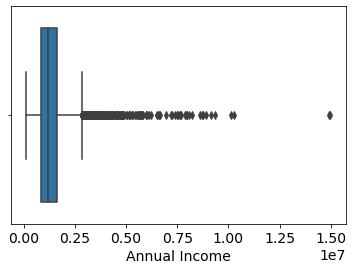

In [38]:
FEATURE = 'Annual Income'
present_feature(all_data,FEATURE)

In [39]:
all_data.loc[all_data[FEATURE] > 1e7]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
6472,Rent,10149344.0,5 years,0.0,10.0,17.500000,270380.0,0.0,22.0,0.0,debt consolidation,Short Term,664818.0,205713.0,61235.0,692.0
36,Home Mortgage,14934114.0,7 years,0.0,7.0,15.400000,177298.0,0.0,NaN,0.0,other,Short Term,99770.0,57722.0,7218.0,746.0
194,Rent,14975610.0,5 years,0.0,5.0,44.299999,155518.0,0.0,NaN,0.0,major purchase,Long Term,133386.0,103968.0,3369.0,738.0
1089,Home Mortgage,10275770.0,6 years,0.0,18.0,15.600000,1242538.0,0.0,NaN,0.0,debt consolidation,Long Term,608432.0,115900.0,79038.0,746.0


In [40]:
data_train.loc[data_train[FEATURE] > 1e7,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 1e7,FEATURE] = all_data[FEATURE].median()

In [41]:
FEATURE = 'Years in current job'

all_data['Years in current job'].value_counts()

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

count    10000.000000
mean         0.031400
std          0.304333
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64


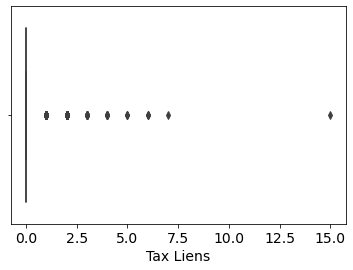

In [42]:
FEATURE = 'Tax Liens'
present_feature(all_data,FEATURE)

In [43]:
all_data[all_data[FEATURE] > 5]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
1214,Rent,3061584.0,2 years,6.0,14.0,28.9,949564.0,6.0,67.0,0.0,debt consolidation,Short Term,100000000.0,352640.0,29595.0,740.0
5373,Own Home,1711881.0,10+ years,6.0,12.0,15.4,551166.0,6.0,26.0,0.0,debt consolidation,Short Term,313654.0,295602.0,36092.0,741.0
5969,Rent,2897310.0,10+ years,7.0,9.0,20.0,434126.0,7.0,54.0,0.0,medical bills,Short Term,782782.0,275576.0,37182.0,716.0
818,Home Mortgage,1161090.0,10+ years,6.0,26.0,15.4,64988.0,7.0,16.0,0.0,debt consolidation,Short Term,108108.0,48773.0,8786.0,705.0
2282,Own Home,1410294.0,10+ years,15.0,5.0,20.1,478984.0,15.0,42.0,0.0,debt consolidation,Short Term,447392.0,301549.0,15513.0,746.0


In [44]:
data_train.loc[data_train[FEATURE] > 5,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 5,FEATURE] = all_data[FEATURE].median()

count    10000.000000
mean        11.144300
std          4.894754
min          1.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         48.000000
Name: Number of Open Accounts, dtype: float64


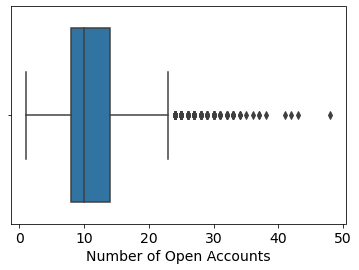

In [45]:
FEATURE = 'Number of Open Accounts'
present_feature(all_data,FEATURE)

In [46]:
data_train.loc[data_train[FEATURE] > 35,  FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 35, FEATURE] = all_data[FEATURE].median()

count    10000.000000
mean        18.319614
std          7.095358
min          3.900000
25%         13.500000
50%         17.000000
75%         22.000000
max         57.700001
Name: Years of Credit History, dtype: float64


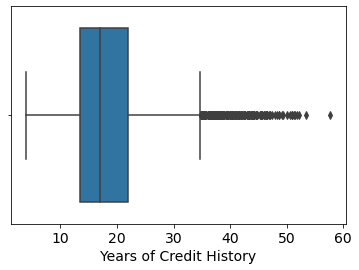

In [47]:
FEATURE = 'Years of Credit History'
present_feature(all_data,FEATURE)

In [48]:
data_train.loc[data_train[FEATURE] > 50,  FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 50, FEATURE] = all_data[FEATURE].median()

count    1.000000e+04
mean     8.865069e+05
std      1.389973e+07
min      0.000000e+00
25%      2.788115e+05
50%      4.781810e+05
75%      7.943595e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64


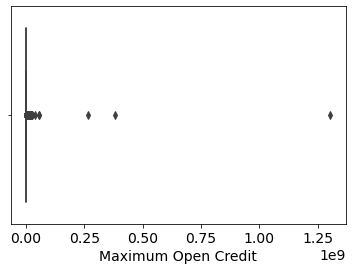

In [49]:
FEATURE = 'Maximum Open Credit'
present_feature(all_data,FEATURE)

In [50]:
all_data.loc[ ((all_data[FEATURE] > 2e7) | (all_data[FEATURE] == 0)), FEATURE].count()

90

In [51]:
data_train.loc[(data_train[FEATURE] > 2e7) | (data_train[FEATURE] == 0),FEATURE] = all_data[FEATURE].median()
data_test.loc[(data_test[FEATURE] > 2e7) | (data_test[FEATURE] == 0),FEATURE] = all_data[FEATURE].median()

count    10000.000000
mean         0.168000
std          0.514591
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64


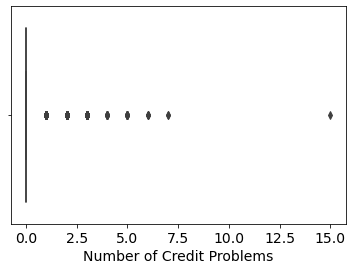

In [52]:
FEATURE = 'Number of Credit Problems'
present_feature(all_data,FEATURE)

In [53]:
data_train.loc[data_train[FEATURE] > 7,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 7,FEATURE] = all_data[FEATURE].median()

count    4561.000000
mean       34.564568
std        21.771950
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64


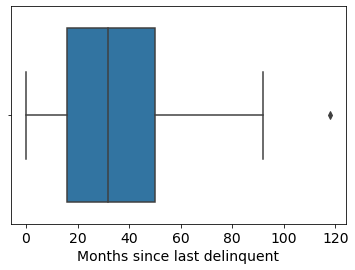

In [54]:
FEATURE = 'Months since last delinquent'
present_feature(all_data,FEATURE)

In [57]:
data_train.loc[data_train[FEATURE] > 100,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 100,FEATURE] = all_data[FEATURE].median()

count    9983.000000
mean        0.114595
std         0.349730
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: Bankruptcies, dtype: float64


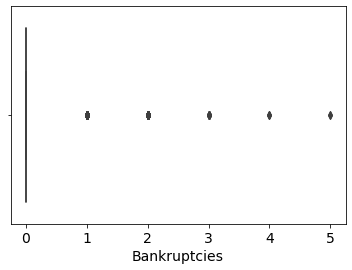

In [58]:
FEATURE = 'Bankruptcies'
present_feature(all_data,FEATURE)

In [59]:
all_data.loc[all_data[FEATURE] > 4,FEATURE].count()

2

In [60]:
FEATURE = 'Purpose'
present_categorical_feature(all_data,FEATURE)

count                  10000
unique                    15
top       debt consolidation
freq                    7917
Name: Purpose, dtype: object
--------------------
business loan            159
buy a car                130
buy house                 53
debt consolidation      7917
educational expenses      13
home improvements        552
major purchase            49
medical bills             98
moving                    12
other                    905
renewable energy           2
small business            31
take a trip               51
vacation                  11
wedding                   17
dtype: int64


In [61]:
FEATURE = 'Term'
present_categorical_feature(all_data,FEATURE)

count          10000
unique             2
top       Short Term
freq            7417
Name: Term, dtype: object
--------------------
Long Term     2583
Short Term    7417
dtype: int64


count        10000.0
mean      11943762.0
std       32008752.0
min          11242.0
25%         180548.5
50%         311718.0
75%         521070.0
max      100000000.0
Name: Current Loan Amount, dtype: float64


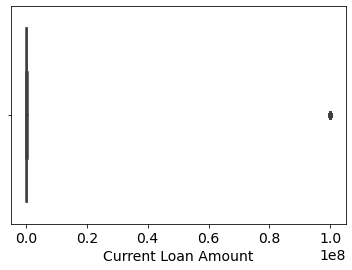

In [63]:
FEATURE = 'Current Loan Amount'
present_feature(all_data,FEATURE)

In [64]:
all_data.loc[all_data[FEATURE] > 1e6, FEATURE].count()

1167

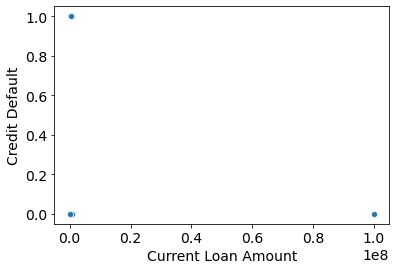

In [65]:
sns.scatterplot(data_train[FEATURE],data_train[TARGET_NAME])

In [66]:
data_train[HELPER_FEATURE] = data_train[FEATURE].apply(lambda x: 0 if x > 1e6 else 1)
data_test[HELPER_FEATURE] = data_test[FEATURE].apply(lambda x: 0 if  x > 1e6 else 1)

count    1.000000e+04
mean     2.914740e+05
std      3.339973e+05
min      0.000000e+00
25%      1.132258e+05
50%      2.090190e+05
75%      3.619500e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64


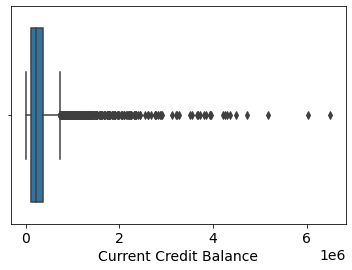

In [67]:
FEATURE = 'Current Credit Balance'
present_feature(all_data,FEATURE)

In [68]:
data_train.loc[data_train[FEATURE] > 5e6,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 5e6,FEATURE] = all_data[FEATURE].median()

count     10000.000000
mean      18303.660156
std       11831.619141
min           0.000000
25%       10059.750000
50%       16200.000000
75%       23888.250000
max      136679.000000
Name: Monthly Debt, dtype: float64


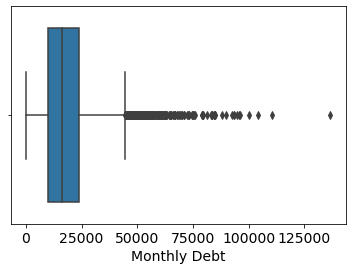

In [69]:
FEATURE = 'Monthly Debt'
present_feature(all_data,FEATURE)

In [70]:
data_train.loc[data_train[FEATURE] > 1e5,FEATURE] = all_data[FEATURE].median()
data_test.loc[data_test[FEATURE] > 5e5,FEATURE] = all_data[FEATURE].median()

count    7930.000000
mean     1171.992188
std      1639.814941
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64


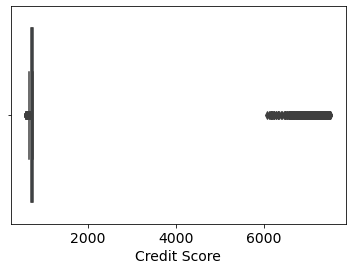

In [71]:
FEATURE = 'Credit Score'
present_feature(all_data,FEATURE)

In [72]:
all_data.loc[all_data[FEATURE] > 1000, FEATURE].count()

560

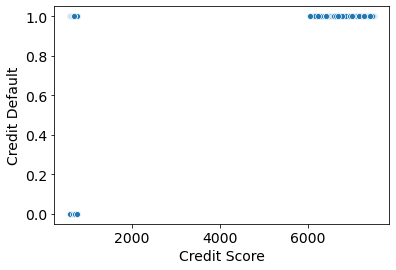

In [73]:
sns.scatterplot(data_train[FEATURE],data_train[TARGET_NAME])

In [74]:
data_train.loc[data_train[HELPER_FEATURE] == 1, HELPER_FEATURE] = data_train.loc[data_train[HELPER_FEATURE] == 1,FEATURE].apply(lambda x: 0 if x < 5000 else 1)
data_test.loc[data_test[HELPER_FEATURE] == 1, HELPER_FEATURE] = data_test.loc[data_test[HELPER_FEATURE] == 1,FEATURE].apply(lambda x: 0 if x < 5000 else 1)

In [75]:
data_train.loc[(data_train[HELPER_FEATURE] ==  0)& (data_train[TARGET_NAME] ==  0)].count()

Home Ownership                  4359
Annual Income                   4359
Years in current job            4164
Tax Liens                       4359
Number of Open Accounts         4359
Years of Credit History         4359
Maximum Open Credit             4359
Number of Credit Problems       4359
Months since last delinquent    2003
Bankruptcies                    4351
Purpose                         4359
Term                            4359
Current Loan Amount             4359
Current Credit Balance          4359
Monthly Debt                    4359
Credit Score                    4359
Credit Default                  4359
exactly delay                   4359
dtype: int64

In [76]:
#Обработка пропусков
all_data = build_all_data()

In [77]:
pass_list = set() # Сюда попадут все признаки по которым есть пропуски
for feature in all_data:
    if all_data[feature].count() != all_data.shape[0]:
        pass_list.add(feature)
        print(f'{feature}:  {all_data[feature].count()}')

Annual Income:  7930
Years in current job:  9543
Months since last delinquent:  4561
Bankruptcies:  9983
Credit Score:  7930


In [84]:
pass_list
pass_list.discard('Years in current job')

In [85]:

for feature in pass_list:
    if not all_data[feature].dtype == np.object:
        data_filter_1 = (data_train[feature].isna()) |  (data_train[feature].isnull())
        data_filter_2 = (data_test[feature].isna()) | (data_test[feature].isnull())
        data_train.loc[data_filter_1,feature] = all_data[feature].mean()
        data_test.loc[data_filter_2,feature] = all_data[feature].mean()   
    else:
        data_train[feature].fillna(all_data[feature].mode()[0], inplace=True)
        data_test[feature].fillna(all_data[feature].mode()[0], inplace=True)

In [86]:
#Анализ данных
all_data = build_all_data() #актуализируем данные во вспомогательном наборе

In [87]:
FEATURE = 'Home Ownership'
pd.get_dummies(all_data[FEATURE]).sum()

Have Mortgage      19
Home Mortgage    4862
Own Home          895
Rent             4224
dtype: int64

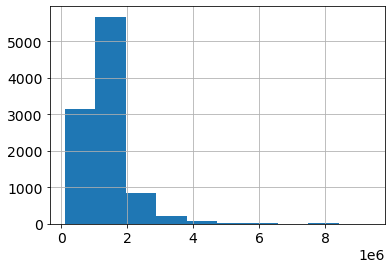

In [88]:
FEATURE = 'Annual Income'
all_data['Annual Income'].hist()

In [89]:
FEATURE = 'Years in current job' 
pd.get_dummies(all_data[FEATURE]).sum()

1 year        657
10+ years    3143
2 years       917
3 years       848
4 years       621
5 years       685
6 years       563
7 years       536
8 years       446
9 years       358
< 1 year      770
dtype: int64

In [90]:
cat_text_to_number(all_data, data_train, FEATURE)
cat_text_to_number(all_data, data_test, FEATURE)

In [92]:
make_dummy(data_train, FEATURE) 
make_dummy(data_test, FEATURE)

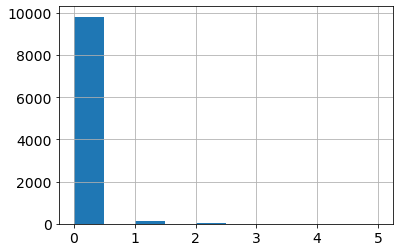

In [93]:
FEATURE = 'Tax Liens' 
all_data[FEATURE].hist()

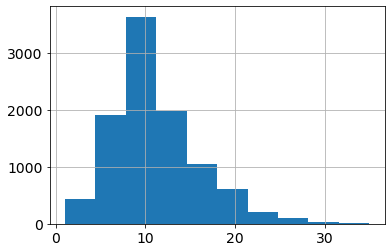

In [94]:
FEATURE = 'Number of Open Accounts' 
all_data[FEATURE].hist()

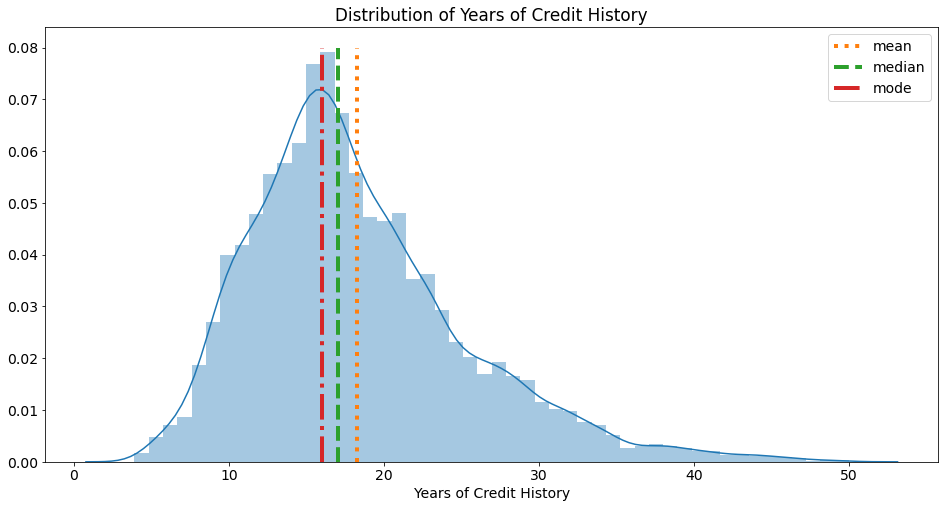

In [95]:
FEATURE = 'Years of Credit History' 
ShowDistribution(all_data, FEATURE, 1e-2, 0.8e-1)

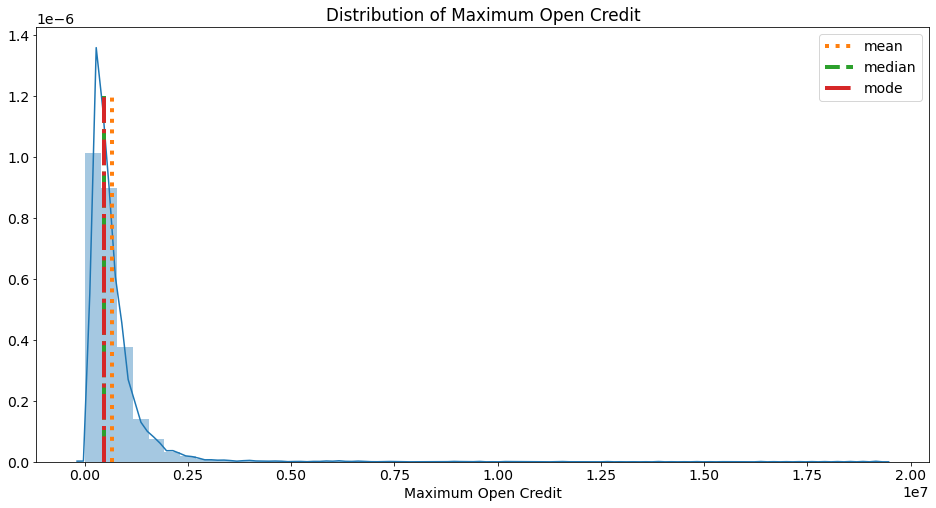

In [96]:
FEATURE = 'Maximum Open Credit' 
ShowDistribution(all_data, FEATURE, 1e-6, 1.2e-6)

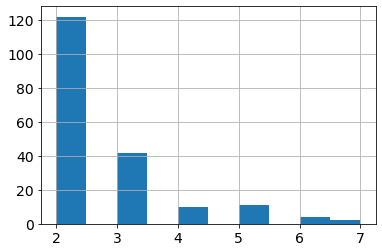

In [97]:
FEATURE = 'Number of Credit Problems' 
all_data.loc[all_data[FEATURE]>1,FEATURE].hist()

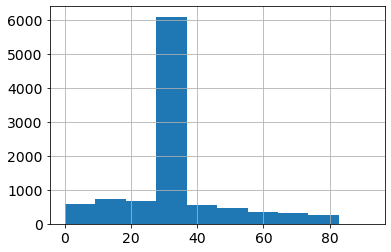

In [98]:
FEATURE = 'Months since last delinquent' 
all_data[FEATURE].hist()

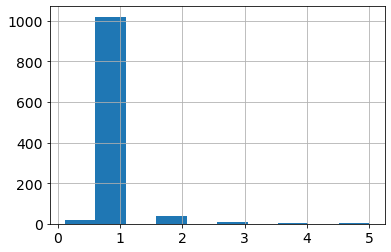

In [99]:
FEATURE = 'Bankruptcies' 
all_data.loc[all_data[FEATURE]>0,FEATURE].hist()

In [100]:
FEATURE = 'Purpose' 
pd.get_dummies(all_data[FEATURE]).sum()

business loan            159
buy a car                130
buy house                 53
debt consolidation      7917
educational expenses      13
home improvements        552
major purchase            49
medical bills             98
moving                    12
other                    905
renewable energy           2
small business            31
take a trip               51
vacation                  11
wedding                   17
dtype: int64

In [101]:
cat_text_to_number(all_data, data_train, FEATURE)
cat_text_to_number(all_data, data_test, FEATURE)

In [102]:
FEATURE = 'Term' 
pd.get_dummies(all_data[FEATURE]).sum()

Long Term     2583
Short Term    7417
dtype: int64

In [103]:
cat_text_to_number(all_data, data_train, FEATURE)
cat_text_to_number(all_data, data_test, FEATURE)

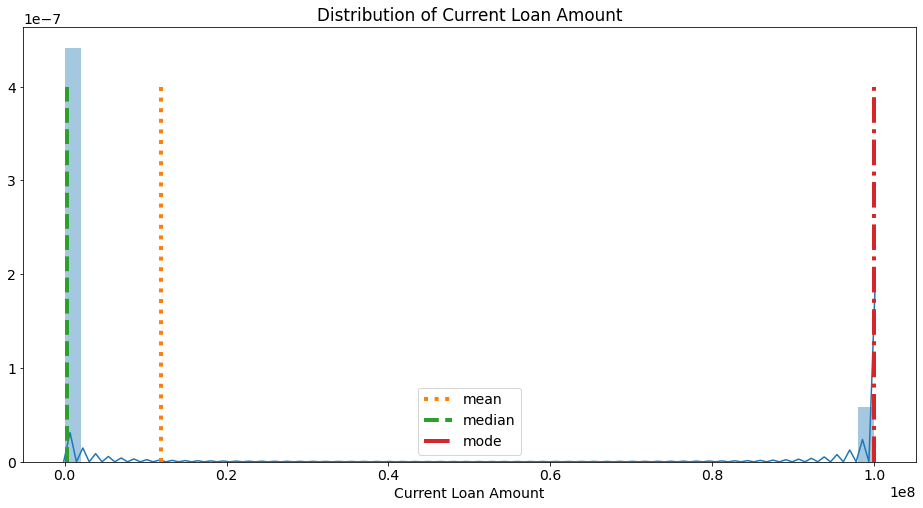

In [104]:
FEATURE = 'Current Loan Amount' 
ShowDistribution(all_data, FEATURE, 0.1e-6, 0.4e-6)

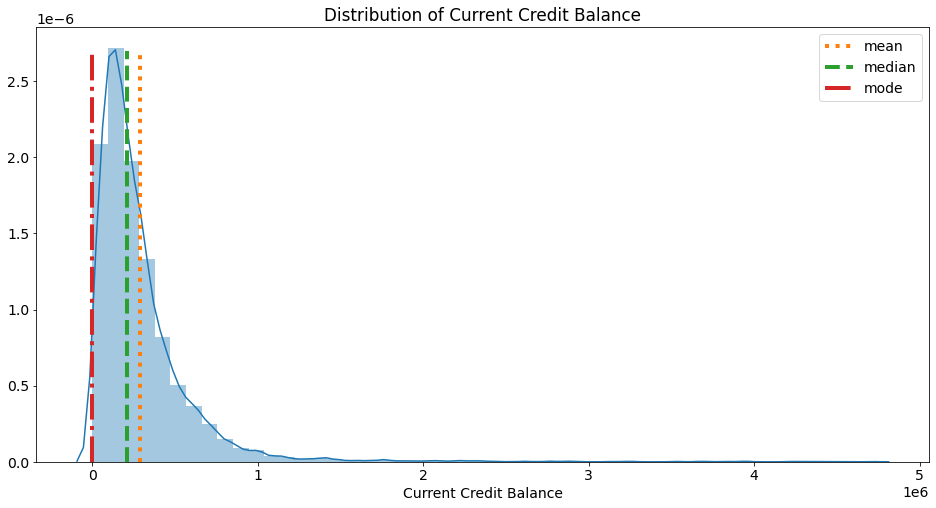

In [105]:
FEATURE = 'Current Credit Balance' 
ShowDistribution(all_data, FEATURE, 1e-4, 0.27e-5)

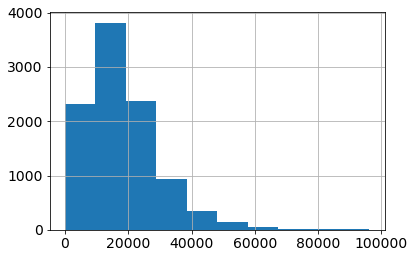

In [106]:
FEATURE = 'Monthly Debt' 
all_data[FEATURE].hist()

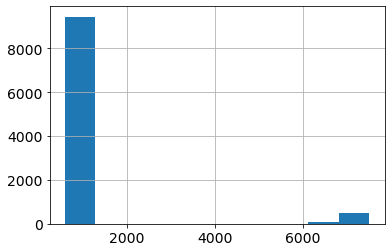

In [107]:
FEATURE = 'Credit Score'
all_data[FEATURE].hist()

In [108]:
data_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [109]:
#Отбор признаков
all_data = build_all_data()

In [110]:
BASE_FEATURE_NAMES = all_data.columns.tolist()
NUM_FEATURE_NAMES = all_data.columns.drop(CAT_FEATURES).tolist()

In [111]:
data_train.insert(0, 'ID', range(len(data_train)))

In [112]:
for feature in CAT_FEATURES:
    for pair in combinations(data_train[feature].unique(),2):
        p = test_feature(data_train,feature,pair, TARGET_NAME)
        if p < 0.01:
            print(feature,p,pair)

exactly delay 5.576540824669816e-108 (0, 1)
Purpose 0.00317344339657794 (3, 11)
Purpose 0.00021520390170564772 (3, 0)
Purpose 0.008518639588496912 (9, 11)
Purpose 0.0036646467408851567 (9, 0)
Purpose 0.0023007381664402558 (5, 11)
Purpose 0.000388811687909952 (5, 0)
Purpose 0.004840424311614478 (1, 11)
Purpose 0.006123555211802671 (1, 0)
Purpose 0.009017021050631893 (11, 6)
Purpose 0.00317344339657794 (3, 11)
Purpose 0.00021520390170564772 (3, 0)
Purpose 0.008518639588496912 (9, 11)
Purpose 0.0036646467408851567 (9, 0)
Purpose 0.0023007381664402558 (5, 11)
Purpose 0.000388811687909952 (5, 0)
Purpose 0.004840424311614478 (1, 11)
Purpose 0.006123555211802671 (1, 0)
Purpose 0.009017021050631893 (11, 6)
Purpose 0.00317344339657794 (3, 11)
Purpose 0.00021520390170564772 (3, 0)
Purpose 0.008518639588496912 (9, 11)
Purpose 0.0036646467408851567 (9, 0)
Purpose 0.0023007381664402558 (5, 11)
Purpose 0.000388811687909952 (5, 0)
Purpose 0.004840424311614478 (1, 11)
Purpose 0.006123555211802671 (1, 

In [114]:
data_train.loc[data_train['Purpose']== 3, 'Purpose'] = 0
data_train.loc[data_train['Purpose']== 5, 'Purpose'] = 0
data_train.loc[data_train['Purpose']== 11, 'Purpose'] = 0

data_test.loc[data_train['Purpose']== 3, 'Purpose'] = 0
data_test.loc[data_train['Purpose']== 5, 'Purpose'] = 0
data_test.loc[data_train['Purpose']== 11, 'Purpose'] = 0

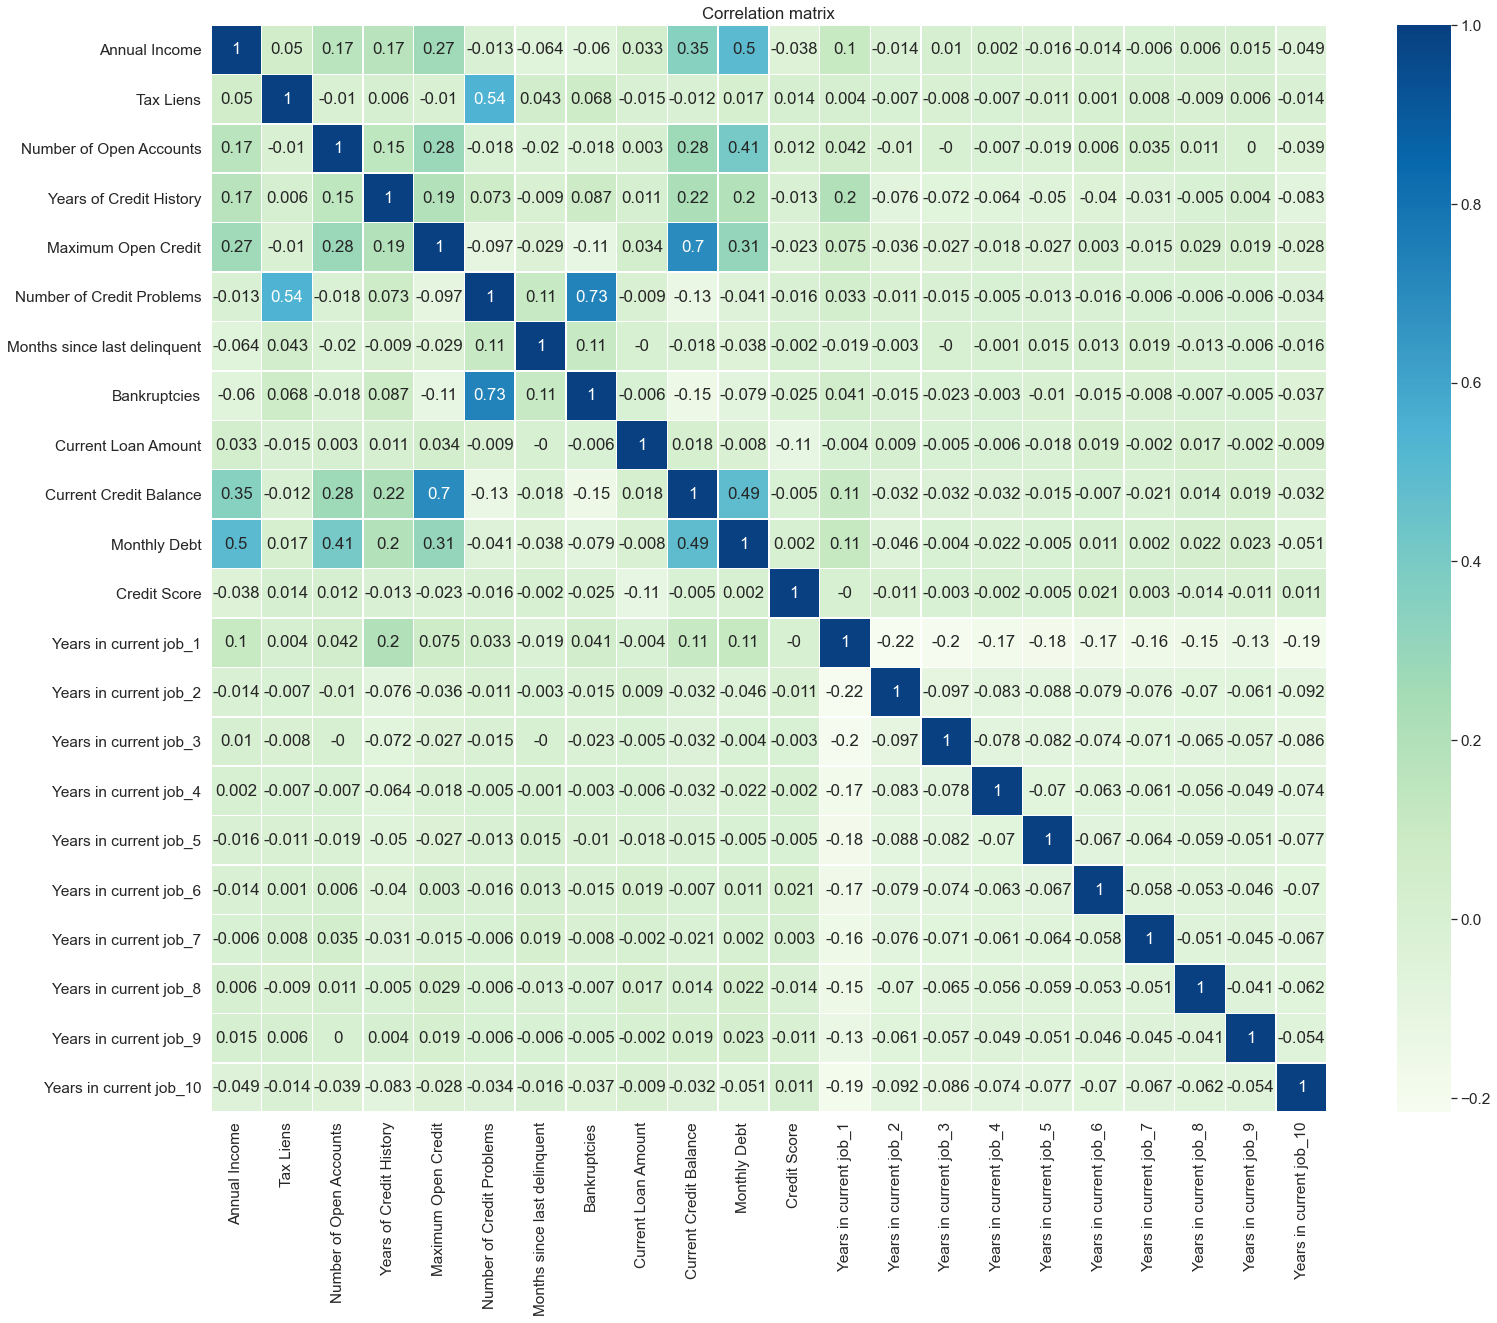

In [115]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(data_train[NUM_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [116]:
data_train['Home Ownership'] = data_train[FEATURE].apply(lambda x: 1.0 if x != 'Own Home' else 2.25) 
data_test['Home Ownership'] = data_test[FEATURE].apply(lambda x: 1.0 if x != 'Own Home' else 2.25) 


data_train['month_balance'] = (data_train['Annual Income']/12) - (data_train['Monthly Debt'] + data_train['Tax Liens']*1.5)*data_train['Home Ownership']
data_test['month_balance'] = (data_test['Annual Income']/12) -(data_test['Monthly Debt'] + data_test['Tax Liens']*1.5)*data_test['Home Ownership']

In [117]:
feature = 'months_of_slavery_left'
data_train[feature] = data_train['Current Credit Balance'] / (data_train['Monthly Debt']+1)
data_test[feature] = data_test['Current Credit Balance'] / (data_test['Monthly Debt']+1)

In [118]:
data_train['rate_4'] = data_train['Number of Open Accounts']  - (data_train['Bankruptcies'] + data_train['Number of Credit Problems'])
data_test['rate_4'] = data_test['Number of Open Accounts']  - (data_test['Bankruptcies'] + data_test['Number of Credit Problems'])

In [119]:
data_train['rate_5'] = (data_train['Bankruptcies']+data_train['Number of Credit Problems'])
data_test['rate_5'] = (data_test['Bankruptcies']+data_test['Number of Credit Problems'])


data_train['rate_5'] = data_train['rate_5'].apply(lambda x: 0 if x == 0 else 1)
data_test['rate_5'] = data_test['rate_5'].apply(lambda x: 0 if x == 0 else 1)

In [120]:
data_train['rate_6'] = (data_train['Months since last delinquent']/12)/data_train['Years of Credit History']
data_test['rate_6'] = (data_test['Months since last delinquent']/12)/data_test['Years of Credit History']

In [121]:
data_train['rate_7'] = data_train['Credit Score']*data_train['rate_6']
data_test['rate_7'] = data_test['Credit Score']*data_test['rate_6']

In [122]:
scaler = StandardScaler()

df_norm = data_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
data_train[NUM_FEATURE_NAMES] = df_norm[NUM_FEATURE_NAMES].copy()

df_norm = data_test.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
data_test = df_norm.copy()

In [123]:
for colname in CAT_FEATURES:
    data_train[colname] = pd.Categorical(data_train[colname])
    data_test[colname] = pd.Categorical(data_test[colname])
    
data_train[CAT_FEATURES].dtypes

exactly delay    category
Purpose          category
Purpose          category
Purpose          category
Purpose          category
dtype: object

In [125]:
#Балансировка классов
y = data_train[TARGET_NAME]
X = data_train.drop(columns=['ID',TARGET_NAME])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [126]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
X_train = df_balanced.drop(columns=[TARGET_NAME])
y_train = df_balanced[TARGET_NAME]

In [128]:
#Подбор моделей
#**k ближайших соседей**
model_knn = KNeighborsClassifier()
model_knn.fit(X_train.drop(columns=CAT_FEATURES), y_train)

y_train_pred = model_knn.predict(X_train.drop(columns=CAT_FEATURES))
y_test_pred = model_knn.predict(X_test.drop(columns=CAT_FEATURES))

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      4328
           1       0.77      0.65      0.71      3344

    accuracy                           0.76      7672
   macro avg       0.77      0.75      0.75      7672
weighted avg       0.76      0.76      0.76      7672

TEST

              precision    recall  f1-score   support

           0     0.7457    0.7781    0.7616      1059
           1     0.4051    0.3628    0.3828       441

    accuracy                         0.6560      1500
   macro avg     0.5754    0.5705    0.5722      1500
weighted avg     0.6456    0.6560    0.6502      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               824  235
1               281  160


In [129]:
#Случайный лес
clf = RandomForestClassifier(max_depth=7, n_estimators = 100, random_state=11)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.95      0.80      4328
           1       0.88      0.47      0.61      3344

    accuracy                           0.74      7672
   macro avg       0.79      0.71      0.71      7672
weighted avg       0.78      0.74      0.72      7672

TEST

              precision    recall  f1-score   support

           0     0.7815    0.9320    0.8501      1059
           1     0.6962    0.3741    0.4867       441

    accuracy                         0.7680      1500
   macro avg     0.7388    0.6531    0.6684      1500
weighted avg     0.7564    0.7680    0.7433      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               987   72
1               276  165


In [131]:
#*XGBoost*
#model_xgb = xgb.XGBClassifier(random_state=21)
#model_xgb.fit(X_train.drop(columns=CAT_FEATURES), y_train)

#y_train_pred = model_xgb.predict(X_train.drop(columns=CAT_FEATURES))
#y_test_pred = model_xgb.predict(X_test.drop(columns=CAT_FEATURES))

#get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [132]:
#*LightGBM*
#model_lgbm = lgbm.LGBMClassifier(random_state=21)
#model_lgbm.fit(X_train, y_train)

#y_train_pred = model_lgbm.predict(X_train)
#y_test_pred = model_lgbm.predict(X_test)

#get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [133]:
#*CatBoost*
#model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
#model_catb.fit(X_train, y_train, cat_features=CAT_FEATURES)

#y_train_pred = model_catb.predict(X_train)
#y_test_pred = model_catb.predict(X_test)

#get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [138]:
import time
#Выбор наилучшей модели, настройка гиперпараметров
%time
params = {'n_estimators':[50, 100, 200, 500, 700],
          'max_depth':[3, 5, 7,9,11]}
cv=KFold(n_splits=4, random_state=21, shuffle=True)


forest = RandomForestClassifier(max_depth=7, n_estimators = 100, random_state=42, class_weight={0:0.5, 1:1.5})
rs = RandomizedSearchCV(forest, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=21, shuffle=True),
                   estimator=RandomForestClassifier(class_weight={0: 0.5,
                                                                  1: 1.5},
                                                    max_depth=7,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [50, 100, 200, 500,
                                                         700]},
                   scoring='f1')

In [139]:
param = rs.best_params_

In [140]:
#Проверка качества, борьба с переобучением
#Добавим веса классам 
clf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators = param['n_estimators'], random_state=17, class_weight={0:0.5, 1:1})
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.68      0.80      4328
           1       0.70      0.98      0.82      3344

    accuracy                           0.81      7672
   macro avg       0.84      0.83      0.81      7672
weighted avg       0.86      0.81      0.81      7672

TEST

              precision    recall  f1-score   support

           0     0.8547    0.5609    0.6773      1059
           1     0.4224    0.7710    0.5457       441

    accuracy                         0.6227      1500
   macro avg     0.6385    0.6659    0.6115      1500
weighted avg     0.7276    0.6227    0.6386      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               594  465
1               101  340


In [141]:
#Обучение финальной модели. Сохранение результатов
df_for_balancing = pd.concat([X, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
X_train = df_balanced.drop(columns=[TARGET_NAME])
y_train = df_balanced[TARGET_NAME]

In [142]:
clf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators = param['n_estimators'], random_state=17, class_weight={0:0.5, 1:1})
clf.fit(X_train, y_train)
y_pred = clf.predict(data_test)

In [143]:
result = pd.DataFrame(data_test.reset_index())
result['Credit Default'] = y_pred

In [144]:
result[['index','Credit Default']].to_csv('Myalo_predictions.csv', index=False)